<a href="https://colab.research.google.com/github/geraldma1998/deep-weather-cleaner/blob/master/deep_weather_cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 391.0MB 1.2MB/s 
     |████████████████████████████████| 460kB 63.6MB/s 
     |████████████████████████████████| 3.8MB 68.1MB/s 


In [0]:
!pip install 'tensorflow-estimator<1.15.0rc0,>=1.14.0rc0' --force-reinstall

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from IPython.display import clear_output
import os

In [0]:
WEATHER_DETECTOR_PATH = "/content/drive/My Drive/haze_to_lines_dataset/weather_detector_dataset/weather_model.h5"

In [0]:
# Haze constants

# Root path
HAZE_PATH = "/content/drive/My Drive/haze_to_lines_dataset/haze_removal_dataset"

# Inputs data path
HAZE_INPATH = HAZE_PATH + "/input"
# Targets data path
HAZE_OUTPATH = HAZE_PATH + "/target"
# Checkpoints path
HAZE_CKPATH = HAZE_PATH + "/checkpoints"

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

LAMBDA = 100

In [0]:
# Rain constants

# Root path
RAIN_PATH = "/content/drive/My Drive/haze_to_lines_dataset/rain_removal_dataset"

# Inputs data path
RAIN_INPATH = RAIN_PATH + "/input"
# Targets data path
RAIN_OUTPATH = RAIN_PATH + "/target"
# Checkpoints path
RAIN_CKPATH = RAIN_PATH + "/checkpoints"


In [0]:

# It resize the input and target image to the height and width specified
def resize(input_image, target_image, height, width):
  
  input_image = tf.image.resize(input_image, [height, width])
  target_image = tf.image.resize(target_image, [height, width])
  
  return input_image, target_image

# It normalize the input and target image to the height and width specified
def normalize(input_image, target_image):
  
  input_image = (input_image / 127.5) - 1
  target_image = (target_image / 127.5) - 1
  
  return input_image, target_image

# It normalize the input and target image to the height and width specified
@tf.function()
def random_jitter(input_image, target_image):
  
  input_image, target_image = resize(input_image, target_image, 286, 286)
  
  stacked_image = tf.stack([input_image, target_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
  
  input_image, target_image = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    target_image = tf.image.flip_left_right(target_image)
  
  return input_image, target_image

def load_image(filename, INPATH, OUTPATH, data_augmentation=True):
  
  input_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)), tf.float32)[..., :3] # Prevents image with more then 3 channels
  target_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + "/" + filename)), tf.float32)[..., :3] # Prevents image with more then 3 channels
  
  input_image, target_image = resize(input_image, target_image, IMAGE_HEIGHT, IMAGE_WIDTH)
  
  if data_augmentation:
    input_image, target_image = random_jitter(input_image, target_image)
  
  input_image, target_image = normalize(input_image, target_image)
  
  return input_image, target_image
  
def load_haze_train_image(filename):
  return load_image(filename, HAZE_INPATH, HAZE_OUTPATH)

def load_haze_test_image(filename):
  return load_image(filename, HAZE_INPATH, HAZE_OUTPATH, False)

def load_rain_train_image(filename):
  return load_image(filename, RAIN_INPATH, RAIN_OUTPATH)

def load_rain_test_image(filename):
  return load_image(filename, RAIN_INPATH, RAIN_OUTPATH, False)



In [0]:
def downsample(filters_number, apply_batchnorm=True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Convolutional layer
  result.add(Conv2D(filters_number,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    # BatchNorm layer
    result.add(BatchNormalization())
  
  # Activation layer
  result.add(LeakyReLU())
  
  return result

In [0]:
def upsample(filters_number, apply_dropout=False):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # Convolutional layer
  result.add(Conv2DTranspose(filters_number,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  
  # BatchNorm layer
  result.add(BatchNormalization())
  
  if apply_dropout:
    # Dropout layer
    result.add(Dropout(0.5))
    
  
  # Activation layer
  result.add(ReLU())
  
  return result

In [0]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  
  down_stack = [
      downsample(64, apply_batchnorm=False), # (bs, 128, 128,  64)
      downsample(128),                       # (bs,  64,  64, 128)
      downsample(256),                       # (bs,  32,  32, 256)
      downsample(512),                       # (bs,  16,  16, 512)
      downsample(512),                       # (bs,   8,   8, 512)
      downsample(512),                       # (bs,   4,   4, 512)
      downsample(512),                       # (bs,   2,   2, 512)
      downsample(512),                       # (bs,   1,   1, 512)
  ]
  
  up_stack = [
      upsample(512, apply_dropout=True),     # (bs,   2,   2, 1024)
      upsample(512, apply_dropout=True),     # (bs,   4,   4, 1024)
      upsample(512, apply_dropout=True),     # (bs,   8,   8, 1024)
      upsample(512),                         # (bs,  16,  16, 1024)
      upsample(256),                         # (bs,  32,  32, 512)
      upsample(128),                         # (bs,  64,  64, 512)
      upsample(64),                          # (bs, 128, 128, 512)
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  last_layer = Conv2DTranspose(filters = 3,
                               kernel_size = 4,
                               strides = 2,
                               padding = "same",
                               kernel_initializer = initializer,
                               activation = "tanh"
                              )
  
  current_input = inputs
  
  skip_connections = []
  
  concat = Concatenate()
  
  for down in down_stack:
    current_input = down(current_input)
    skip_connections.append(current_input)
    
  skip_connections = reversed(skip_connections[:-1])
    
  for up, skip_connection in zip(up_stack, skip_connections):
    current_input = up(current_input)
    current_input = concat([current_input, skip_connection])
    
  last_layer = last_layer(current_input)
  
  return Model(inputs=inputs, outputs=last_layer)


In [0]:
def Discriminator():
  
  ini = Input(shape=[None, None, 3], name="input_image")
  gen = Input(shape=[None, None, 3], name="generated_image")
  
  con = concatenate([ini, gen])
  
  initializer = tf.random_normal_initializer(0, 0.2)
  
  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last_layer = Conv2D(filters=1,
                      kernel_size=4,
                      strides=1,
                      kernel_initializer=initializer,
                      padding="same")(down4)
  
  return Model(inputs=[ini,gen],outputs=last_layer)



In [0]:
def discriminator_loss(disc_real_output, disc_generated_output, loss_object):
  
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:

def generator_loss(disc_generated_output, gen_output, target, loss_object):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolutte error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss


In [0]:
def generate_images(model, test_input, tar, current_path, save_filename=False, display_imgs=True):
  
  prediction = model(test_input, training=False)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(current_path + "/output/" + save_filename + ".jpg", prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  
  title = ["Input Image", "Ground Truth", "Predicted Image"]
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis("off")
      
  plt.show()

In [0]:
@tf.function()
def train_step(input_image, target_image, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_target_discr = discriminator([target_image, input_image], training=True)

    discr_loss = discriminator_loss(output_target_discr, output_gen_discr, loss_object)

    gen_loss = generator_loss(output_gen_discr, output_image, target_image, loss_object)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))


In [0]:
def train(training_dataset, test_dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, checkpoint, checkpoint_prefix, loss_object, train_urls, path):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in training_dataset:
      print("epoch " + str(epoch) + " - train: " + str(imgi) + "/" + str(len(train_urls)))
      imgi += 1
      train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer, loss_object)
      clear_output(wait=True)

    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp,tar, path, str(imgi) + "_" + str(epoch), display_imgs=True)
      imgi += 1

    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

In [17]:
#Get haze dataset information

haze_imgurls = !ls -1 "{HAZE_INPATH}"

# Size of our dataset
size_haze_dataset = 75
haze_train_len = round(size_haze_dataset * 0.90)

# Images random list
random_haze_urls = np.copy(haze_imgurls)

np.random.seed() # It's important just for the tutorial
np.random.shuffle(random_haze_urls)

# Data partions
train_haze_urls = random_haze_urls[:haze_train_len]
test_haze_urls = random_haze_urls[haze_train_len:size_haze_dataset]

print(len(haze_imgurls),len(train_haze_urls),len(test_haze_urls))

75 68 7


In [18]:
#Get rain dataset information

rain_imgurls = !ls -1 "{RAIN_INPATH}"

# Size of our dataset
size_rain_dataset = 200
rain_train_len = round(size_rain_dataset * 0.95)

# Images random list
random_rain_urls = np.copy(rain_imgurls)

np.random.seed() # It's important just for the tutorial
np.random.shuffle(random_rain_urls)

# Data partions
train_rain_urls = random_rain_urls[:rain_train_len]
test_rain_urls = random_rain_urls[rain_train_len:size_rain_dataset]

print(len(rain_imgurls),len(train_rain_urls),len(test_rain_urls))

200 190 10


In [0]:
# Here we load the train and test haze dataset
haze_generator = Generator()
haze_discriminator = Discriminator()

haze_train_dataset = tf.data.Dataset.from_tensor_slices(train_haze_urls)
haze_train_dataset = haze_train_dataset.map(load_haze_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
haze_train_dataset = haze_train_dataset.batch(1)

haze_test_dataset = tf.data.Dataset.from_tensor_slices(test_haze_urls)
haze_test_dataset = haze_test_dataset.map(load_haze_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
haze_test_dataset = haze_test_dataset.batch(1)


In [0]:
# Here we load the train and test rain dataset
rain_generator = Generator()
rain_discriminator = Discriminator()

rain_train_dataset = tf.data.Dataset.from_tensor_slices(train_rain_urls)
rain_train_dataset = rain_train_dataset.map(load_rain_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
rain_train_dataset = rain_train_dataset.batch(1)

rain_test_dataset = tf.data.Dataset.from_tensor_slices(test_rain_urls)
rain_test_dataset = rain_test_dataset.map(load_rain_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
rain_test_dataset = rain_test_dataset.batch(1)


In [0]:
haze_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
rain_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# Haze generator and discriminator optimizer
haze_generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
haze_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

haze_checkpoint_prefix = os.path.join(HAZE_CKPATH, "ckpt")
haze_checkpoint = tf.train.Checkpoint(generator_optimizer=haze_generator_optimizer,
                                 discriminator_optimizer=haze_discriminator_optimizer,
                                 generator=haze_generator,
                                 discriminator=haze_discriminator)


In [0]:
# Rain generator and discriminator optimizer
rain_generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
rain_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

rain_checkpoint_prefix = os.path.join(RAIN_CKPATH, "ckpt")
rain_checkpoint = tf.train.Checkpoint(generator_optimizer=rain_generator_optimizer,
                                 discriminator_optimizer=rain_discriminator_optimizer,
                                 generator=rain_generator,
                                 discriminator=rain_discriminator)


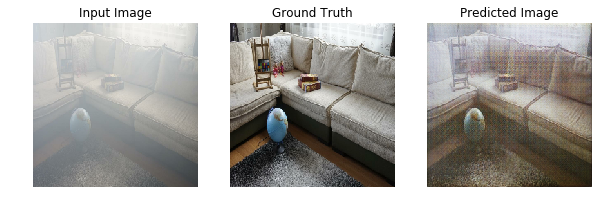

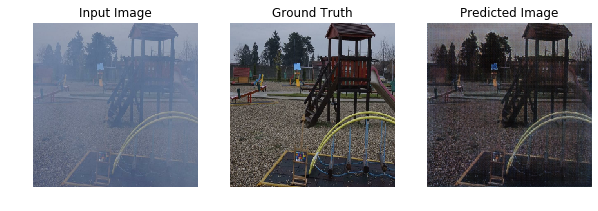

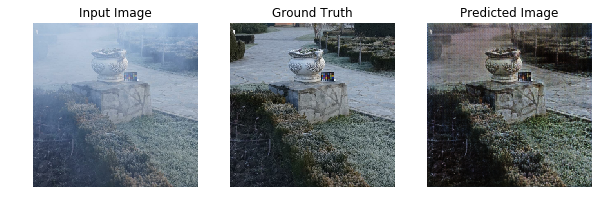

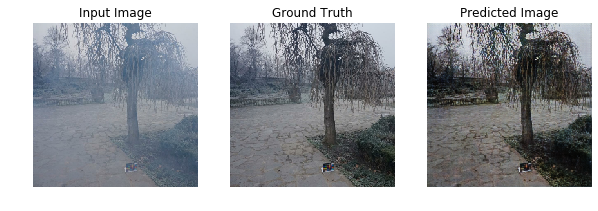

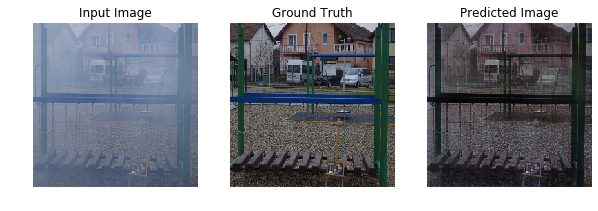

In [0]:
#Haze training
train(haze_train_dataset, haze_test_dataset, 150, haze_generator, haze_discriminator, haze_generator_optimizer, haze_discriminator_optimizer, haze_checkpoint, haze_checkpoint_prefix, haze_loss_object, train_haze_urls, HAZE_PATH)

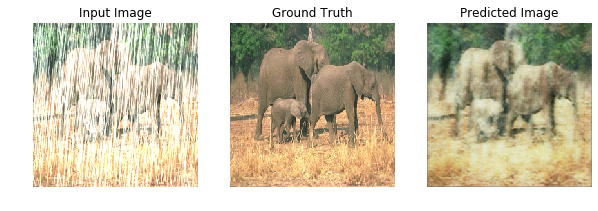

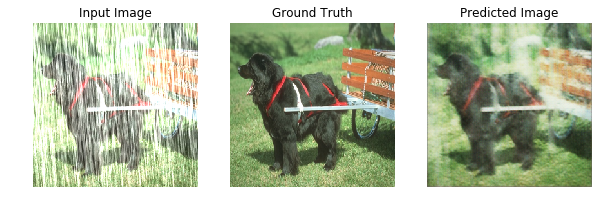

In [0]:
#Rain training
train(rain_train_dataset, rain_test_dataset, 150, rain_generator, rain_discriminator, rain_generator_optimizer, rain_discriminator_optimizer, rain_checkpoint, rain_checkpoint_prefix, rain_loss_object, train_rain_urls, RAIN_PATH)

In [25]:
rain_checkpoint.restore(tf.train.latest_checkpoint(RAIN_CKPATH))

In [117]:
haze_checkpoint.restore(tf.train.latest_checkpoint(HAZE_CKPATH))

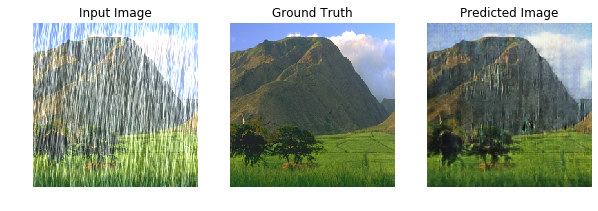

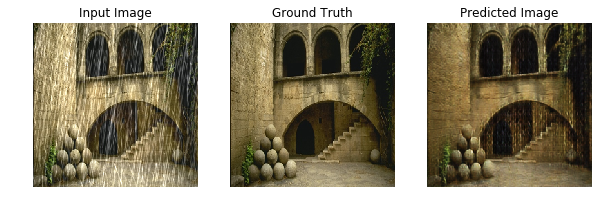

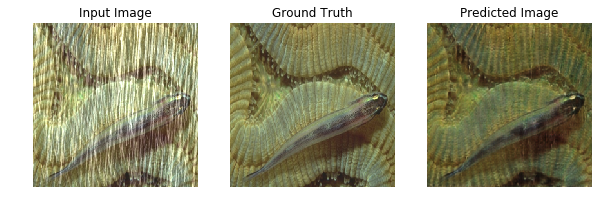

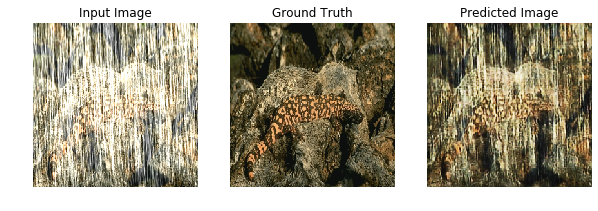

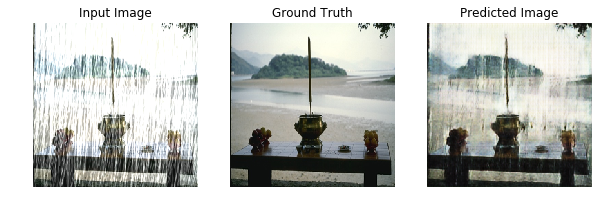

In [28]:
for inp, tar in rain_test_dataset.take(5):
    generate_images(rain_generator, inp, tar, "")

In [0]:
weather_classificator = tf.keras.models.load_model(WEATHER_DETECTOR_PATH)
weather_classificator.summary()

In [51]:
from tqdm import tqdm
from keras.preprocessing import image

Using TensorFlow backend.


In [0]:
def load_classificator_images(urls, path_file):
  train_image = []
  for i in tqdm(range(urls.shape[0])):
      img = image.load_img(path_file+"/"+urls[i], target_size=(28,28,3), grayscale=False)
      img = image.img_to_array(img)
      img = img/255
      train_image.append(img)
  X = np.array(train_image)
  
  return X


In [172]:
WEATHER_TESTING_DATASET = "/content/drive/My Drive/haze_to_lines_dataset/weather_detector_dataset/testing"
weather_imgurls = !ls -1 "{WEATHER_TESTING_DATASET}"
len(weather_imgurls)

6

In [0]:
weather_imgurls = np.copy(weather_imgurls)


In [0]:
def load_testing_image(filename, INPATH, data_augmentation=True):
  
  input_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)), tf.float32)[..., :3] # Prevents image with more then 3 channels
  target_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)), tf.float32)[..., :3] # Prevents image with more then 3 channels
  
  input_image, target_image = resize(input_image, target_image, IMAGE_HEIGHT, IMAGE_WIDTH)
  
  if data_augmentation:
    input_image, target_image = random_jitter(input_image, target_image)
  
  input_image, target_image = normalize(input_image, target_image)
  
  return input_image,input_image
  
def load_weather_testing(filename):
  return load_testing_image(filename, WEATHER_TESTING_DATASET, False)

In [175]:
testing_dataset = load_classificator_images(weather_imgurls,WEATHER_TESTING_DATASET)
weather_testing_data = tf.data.Dataset.from_tensor_slices(weather_imgurls)
weather_testing_data = weather_testing_data.map(load_weather_testing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
weather_testing_data = weather_testing_data.batch(1)


100%|██████████| 6/6 [00:00<00:00,  6.80it/s]

In [176]:
weather_prediction = weather_classificator.predict_classes(testing_dataset)
weather_prediction

array([0, 0, 0, 1, 1, 1])

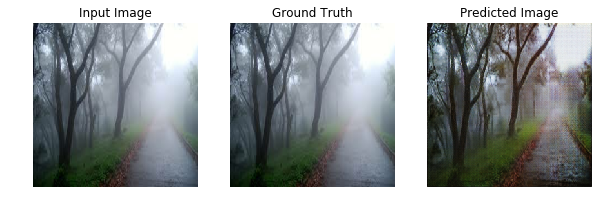

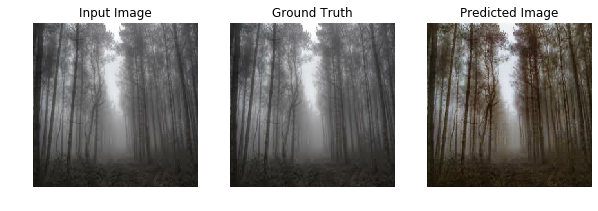

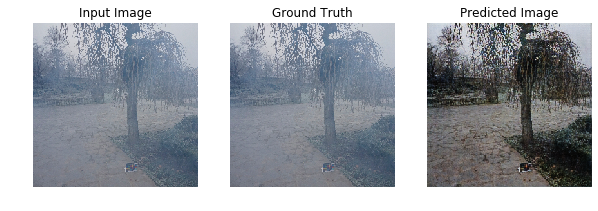

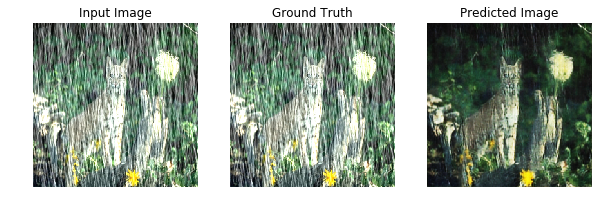

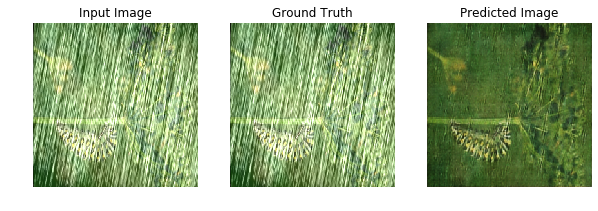

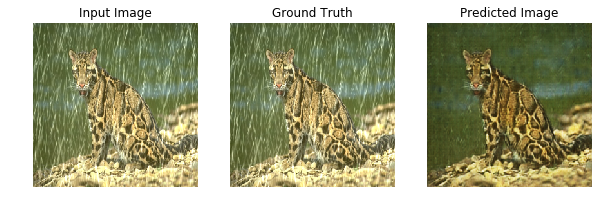

In [177]:
current_position = 0
for inp, tar in weather_testing_data.take(len(testing_dataset)):
  if (weather_prediction[current_position] == 0):
    generate_images(haze_generator, inp, tar, "")
  else:
    generate_images(rain_generator, inp, tar, "")
  current_position += 1